# Deep Layer Visualization Tutorial


First we import the needed libraries.

In [13]:
import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

Next we import the MNIST data files we are going to be classifying. This database contains images of thousands of handwritten digits, and their proper labels. 

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Next we define our convolutional network. It will be a network with three sets of convolution -> pooling layers, followed by a fully connected softmax layer. I have choosen 5,5,20 to begin with. Feel free to adjust the number of convolutional filters at each layer. It is these filters we will be visualizing, so we can see in realtime what features are learned from the dataset with more or less filters.

In [15]:
sess = tf.Session()

x = tf.placeholder(tf.float32, [None, 784],name="x-in")
y_ = tf.placeholder(tf.float32, [None, 10],name="y-in")

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1,28,28,1])
W_conv1 = weight_variable([5, 5, 1, 5])
b_conv1 = bias_variable([5])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 5, 5])
b_conv2 = bias_variable([5])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_conv3 = weight_variable([5, 5, 5, 20])
b_conv3 = bias_variable([20])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

W_fc1 = weight_variable([7 * 7 * 20, 10])
b_fc1 = bias_variable([10])
h_conv3_flat = tf.reshape(h_conv3, [-1, 7*7*20])
keep_prob = tf.placeholder("float")
h_conv3_drop = tf.nn.dropout(h_conv3_flat, keep_prob)
y_conv = tf.nn.softmax(tf.matmul(h_conv3_drop, W_fc1) + b_fc1)

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

We then train the network using batch gradient descent with Adam optimization. Feel free to adjust the batch size and number of iterations to see how it effects the model accuracy.

In [16]:
sess.run(tf.initialize_all_variables())
iterations = 0
batchSize = 50
while iterations < 1001:
    batch = mnist.train.next_batch(batchSize)
    train_step.run(session=sess, feed_dict={x:batch[0],y_:batch[1], keep_prob:0.5})
    if iterations%100 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={x:batch[0],y_:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(iterations, trainAccuracy))
    iterations += 1

step 0, training accuracy 0.06
step 100, training accuracy 0.26
step 200, training accuracy 0.44
step 300, training accuracy 0.48
step 400, training accuracy 0.68
step 500, training accuracy 0.66
step 600, training accuracy 0.86
step 700, training accuracy 0.86
step 800, training accuracy 0.78
step 900, training accuracy 0.84
step 1000, training accuracy 0.9


In [18]:
testAccuracy = accuracy.eval(session=sess, feed_dict={x:mnist.test.images,y_:mnist.test.labels, keep_prob:1.0})
print("test accuracy %g"%(testAccuracy))

test accuracy 0.8869


Now we define a couple functions that will allow us to visualize the network. The first gets the activations at a given layer for a given input image. The second plots those activations in a grid.

In [19]:
def getActivations(layer,stimuli):
    units = layer.eval(session=sess,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [20]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    for i in xrange(0,filters):
        plt.subplot(7,6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

Now we can choose an image to pass through the network to visualize the network activation, and look at the raw pixels of that image.

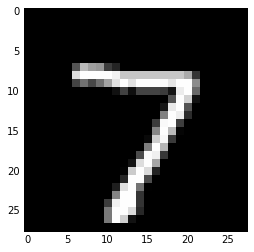

In [23]:
imageToUse = mnist.test.images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")

Now we can look at how that image activates the neurons of the first convolutional layer. Notice how each filter has learned to activate optimally for different features of the image. 

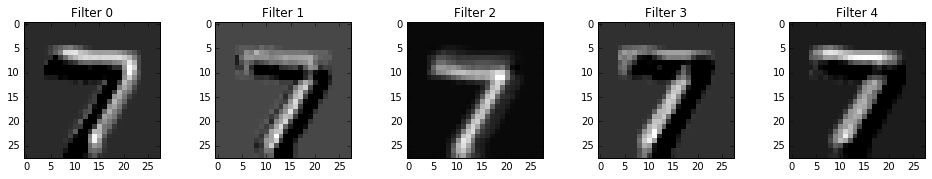

In [24]:
getActivations(h_conv1,imageToUse)

We can do this again for the second layer...

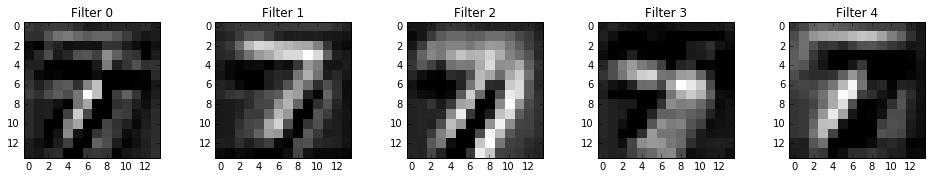

In [25]:
getActivations(h_conv2,imageToUse)

...and the third.

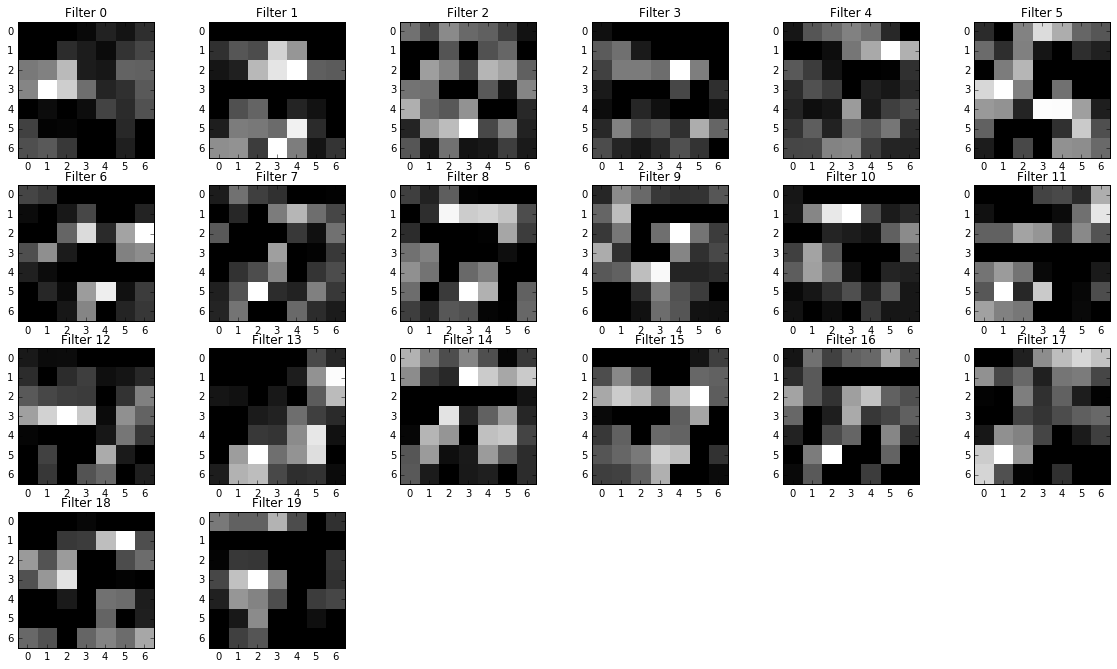

In [26]:
getActivations(h_conv3,imageToUse)

The model we used here is of a relatively simple network, but the visualization technique can be extended to give insights into any convolutional network.